In [3]:
import numpy as np
import os

# inputfolder = '..\\data\\06_02_2022-19_11_19_test_run_10minpixSTCE2_0v_2\\{}'
inputfolder = '..\\data\\06_04_2022-21_51_26stce2_gradientcal5_AC0.5V_600sec\\{}'

# time px py v i
# data = np.zeros((1,8,8,1,1))
data = {}

for file in os.listdir(inputfolder.format('')):
    if file.endswith(".txt"):
        data[file[:-4]] = np.loadtxt(inputfolder.format(file)) # t V IOError
        # print(data[file[:-4]].shape)

mult_file = np.loadtxt(inputfolder.format("gradient.txt")) # Non numeric lines should start with # !
mult_file_matrix = np.zeros((8,8))
for line in range(mult_file.shape[0]):
    mult_file_matrix[int(mult_file[line,0]),int(mult_file[line,1])] = mult_file[line,2]
print ( mult_file.shape)

print("{} files loaded.".format(len(data)))

(64, 3)
65 files loaded.


Text(0.5, 0, 'time')

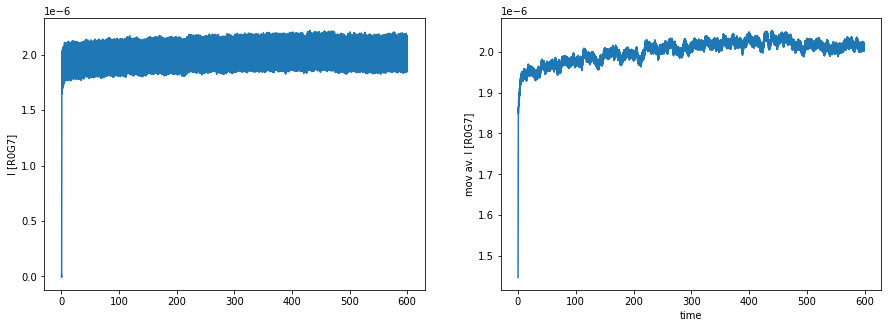

In [4]:
def mov_av(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2, figsize=(15,5))
pixelid = 'R0G7'
mov_av_w = 15
ax[0].plot(data[pixelid][:,0], data[pixelid][:,2])
ax[1].plot(data[pixelid][:-mov_av_w+1,0], mov_av(data[pixelid][:,2], mov_av_w))
ax[0].set_ylabel("I [{}]".format(pixelid))
ax[1].set_ylabel("mov av. I [{}]".format(pixelid))
ax[1].set_xlabel("time")

In [5]:
sm_data = {}
for k,v in data.items():
    newI = mov_av(v[:,2],mov_av_w)
    newV = mov_av(v[:,1],mov_av_w)
    newT = v[:-mov_av_w+1,0]
    sm_data[k] = np.vstack([newT,newV,newI]).T

In [6]:
mintime = np.min([np.max(val[:,0]) for val in sm_data.values()])
minpoints = np.min([val.shape[0] for val in sm_data.values()])
# maxcurrent = [np.max(val[:,2]) for val in sm_data.values()]
# mincurrent = [np.min(val[:,2]) for val in sm_data.values()]
print("Min pixel total time:",mintime)
print("Min pixel points:",minpoints)
fps = round(minpoints/mintime)
print("FPS:",fps)
print("Timestep:",1/fps)
# print("Max current:",maxcurrent)
# print("Min current:",mincurrent)

Min pixel total time: 7.0
Min pixel points: 50
FPS: 7
Timestep: 0.14285714285714285


In [7]:
import cv2, tqdm
from PIL import Image
size = 8*30, 8*30
out = cv2.VideoWriter('../output/video_{}.mp4'.format(inputfolder[8:-3]), cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]), False)

# darkcurrent = 0

for frame_ind in tqdm.tqdm(range(round(mintime*fps))):
    time = frame_ind/fps
    frame = np.zeros((8,8))

    for g_i in range(7,-1,-1):
        for r_i in range(0,8,1):
            frame_data = sm_data['R{}G{}'.format(r_i, g_i)]
            maxcurrent = np.average(frame_data[:20,2])
            mincurrent = 0#np.min(frame_data[:,2])
            time_ind = np.argmin( np.abs(frame_data[:,0] - time) )
            curr = frame_data[time_ind,2]
            # assert curr - mincurrent >= 0
            frame[7-g_i, r_i] = round((curr-mincurrent)/(maxcurrent-mincurrent)*0.5 * 255) * mult_file_matrix[r_i, g_i]
            # if ((r_i == 0) and (g_i == 0)): frame[g_i-7, r_i] = 0
    # data = np.random.randint(0, 256, size, dtype='uint8')
    frame = np.repeat(np.repeat(frame,30,0),30,1)
    # break
    # img = Image.fromarray(frame)
    # img = img.convert("L")
    # img.save("../output/frames/{}.png".format(frame_ind))

    out.write(frame.astype('uint8'))
out.release()

100%|██████████| 49/49 [00:00<00:00, 212.69it/s]
